<a href="https://colab.research.google.com/github/EmmanueleVilla/mnist-droid/blob/main/Mnist_classifier_to_tensorflow_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# NOTE: After executing this cell you may need to restart the runtime!
!pip install tflite-support

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# Various imports
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb
import os, random
tf.__version__

'2.8.2'

In [13]:
# Import the dataset and create train, test and val
mnist = tf.keras.datasets.mnist
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()
val_data = test_data[:5000]
val_labels = test_labels[:5000]

train_data = tf.expand_dims(train_data, -1)
test_data = tf.expand_dims(test_data, -1)
val_data = tf.expand_dims(val_data, -1)

In [26]:
!echo "0\n1\n2\n3\n4\n5\n6\n7\n8\n9" > labels.txt

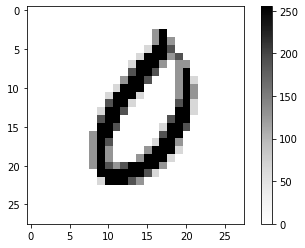

In [15]:
# Show a data example
plt.figure()
plt.imshow(tf.squeeze(random.choice(train_data)), cmap="Greys")
plt.colorbar()
plt.grid(False)
plt.show()

In [16]:
# Create the neural network model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Lambda(lambda x : tf.cast(x, tf.float32) / 255.0),
        tf.keras.layers.Conv2D(32, 5, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 5, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ]
)

In [17]:
# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=["accuracy"]
)

In [18]:
# Fit the model
history = model.fit(train_data, train_labels, epochs=15, validation_data=(val_data, val_labels))

Epoch 1/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4464 - accuracy: 0.8665 - val_loss: 0.2086 - val_accuracy: 0.9356
Epoch 2/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1401 - accuracy: 0.9579 - val_loss: 0.1576 - val_accuracy: 0.9486
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1031 - accuracy: 0.9681 - val_loss: 0.0998 - val_accuracy: 0.9676
Epoch 4/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0832 - accuracy: 0.9748 - val_loss: 0.0893 - val_accuracy: 0.9720
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0721 - accuracy: 0.9778 - val_loss: 0.0797 - val_accuracy: 0.9768
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0640 - accuracy: 0.9808 - val_loss: 0.0731 - val_accuracy: 0.9782
Epoch 7/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0583 - accuracy: 0.9820 - val_loss: 0.0648 - val_accuracy:

In [19]:
# 6. Evaluate the model
test_data_exp = np.expand_dims(test_data, axis=-1)
loss, accuracy = model.evaluate(test_data_exp, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0355 - accuracy: 0.9889


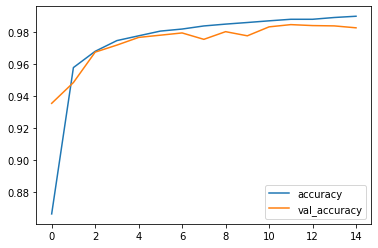

In [20]:
# 7. Plot the training history
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

In [21]:
# Convert the model to tf lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to file
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [27]:
""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Shadowings mnist digit classifier"
model_meta.description = ("Shadowings mnist digit classifier")
model_meta.version = "v1"
model_meta.author = "TensorFlow"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "one channel per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(28, 28))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.GRAYSCALE)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 10 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("labels.txt")
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

populator = _metadata.MetadataPopulator.with_model_file("model.tflite")
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["labels.txt"])
populator.populate()

In [28]:
from google.colab import files
files.download("model.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>